# Minimal movie-to-user recommendation

![title](minimal_example_graph.png)

### User nu should get a higher ranking on m3 than on m4. Because m3 and m1 has the same genre g1

In [1]:
# minimal example
import numpy as np
import csv
import pandas as pd
from scipy.sparse import csr_matrix

# multiplication of M and r
def mul_MR( Mat, vec ):
    res_list = []
    
    for row in range(0,3):
        res_col = 0
        for col in range(0,3):
            #print(row,col)
            #print('Mat[row][col]', Mat[row][col])
            #print('vec', vec[col][0])
            
            # 0 * any_vector sould result in 0
            if not isinstance( Mat[row][col], int): # if Mat[row][col] != 0:
                res_col = res_col + np.dot(Mat[row][col], vec[col][0])
                
        #print('res_col', res_col)
        res_list.insert(row, res_col)
    
    return  np.array([[res_list[0]],[res_list[1]], [res_list[2]]])

# data:
# 4 user, 4 movies, 2 genres
# the user nu have seen m1
# he should get a higher rank on m3 than on m4, because m3 has the same genre g1 like m1

# My Theory of the Notation:
# Notation P_um(i,j) probability from user j to movie i. The i and j gives the "orientation" of the matrix. 
# So i for rows(movies) and j for columns(users)

# ------- Transition matrices (stochastic) -------
# user-movie
#     u1 u2 u3 nu 
# m1  1  0  0  1
# m2  0  1  0  0
# m3  0  0 0.5 0
# m4  0  0 0.5 0
P_um = np.array([[1, 0, 0, 1], \
                 [0, 1, 0, 0], \
                 [0, 0, 0.5, 0], \
                 [0, 0, 0.5, 0]])
# movie-user
#     m1 m2 m3 m4 
# u1 0.5  0  0  0
# u2  0  1  0  0
# u3  0  0  1  1
# nu 0.5 0  0  0
P_mu = np.array([[0.5, 0, 0, 0], \
                 [0, 1, 0, 0], \
                 [0, 0, 1, 1], \
                 [0.5, 0, 0, 0]])

# movie-genre 
#    m1   m2   m3   m4
# g1 1    1    1    0
# g2 0    0    0    1
P_mg = np.array([[1, 1, 1, 0], \
                 [0, 0, 0, 1]])

# genre-movie
#     g1  g2
# m1 1/3  0
# m2 1/3  0
# m3 1/3  0
# m4  0   1
P_gm = np.array([[1.0/3, 0], \
                 [1.0/3, 0], \
                 [1.0/3, 0], \
                 [0, 1]])

print('P_um, P_mu', P_um.shape, P_mu.shape)
print('P_mg, P_gm', P_mg.shape, P_gm.shape)

# -Parameters
# Transition Weight or influence weight
# Julian: Außerdem müssen sich alle Axy für ein festes y zu 1 summieren.

# alpha_mn is the transition weight that node n gets from node m. All transition weight to n sum up to 1.

# query user node alpha_quu is like the chance for a personalized teleport
alpha_quu = 0.2

# for users
alpha_mu = 0.8 # 1-alpha_quu #User nodes gets transition weights from movie-nodes and user_query.
# for movies
alpha_um = 0.75 # Movie nodes gets transition weights from user-nodes and genre-nodes.
alpha_gm = 0.25 # Movie nodes gets transition weights from user-nodes and genre-nodes.
# for genres
alpha_mg = 1 # Genre nodes gets transition weights from movie nodes.



# ----- User query vector qu -----

# Julian: Für movie-to-user Recommendation ist der Query-Vektor ein 4-dim. Einheitsvektor, z.B. (0,0,0,1)^T für nu.
# Definition 5
#    1  2  3  4
# u1 1  0  0  0
# u2 0  1  0  0
# u3 0  0  1  0
# nu 0  0  0  1  <-- 
# q_u = (0,0,0,1)^T
q_u = np.array([
        [0], 
        [0], 
        [0], 
        [1]
    ])


# ---- q -----
q = np.array([
        [np.dot(alpha_quu, q_u)],
        [np.array([[0],[0],[0],[0]])],
        [np.array([[0],[0]])]
    ], dtype=object)

# print q
print('q', q)


# ---- M ----
M = np.array([[0, np.dot(alpha_mu, P_mu), 0], \
              [np.dot(alpha_um, P_um), 0, np.dot(alpha_gm, P_gm)], \
              [0, np.dot(alpha_mg, P_mg), 0]\
             ], dtype=object) # TODO check dtype=object
print('M', M.shape)


# distribution probability vectors
# do i need a init r?
dpv_u = np.array([np.ones(4)/4], dtype=object )
dpv_m = np.array([np.ones(4)/4], dtype=object )
dpv_g = np.array([np.ones(2)/2], dtype=object )

print('dpv_u', dpv_u.shape)
print('dpv_m', dpv_m.shape)
print('dpv_g', dpv_g.shape)


# r
r = np.array([[dpv_u.T], [dpv_m.T], [dpv_g.T]]) # (3,1) 

print('r', r.shape)
print('r[0][0]', r[0][0].shape)
print('r[1][0]', r[1][0].shape)
print('r[2][0]', r[2][0].shape)


# ---- Iterate ----
# r(t+1) = Mr(t)+q

# M1*r1 : 1. row of matrixmultiplication
#np.dot(M1[0][0], r1[0][0]) #works 
#np.dot(M1[0][1], r1[1][0]) #works 
#np.dot(M1[0][2], r1[2][0]) #works 

#res = mul_MR(M, r)
# problem:
#np.dot(M, r) # error : operands could not be broadcast together with shapes (2,3) (3,1)
#MM*r # error: shapes (3,2) and (1,3) not aligned: 2 (dim 1) != 1 (dim 0)
# solved by own multiplication method


print '-----------------------'

#print method
def printR(t, rVector):
    res = rVector
    print 'iteration '+ str(t)
    for index, i in enumerate(res[0][0]):
        print('User '+str(index+1)+': ' + str(i[0]))
    
    for index, i in enumerate(res[1][0]):
        print('Movie '+str(index+1)+': ' + str(i[0]))
        
    for index, i in enumerate(res[2][0]):
        print('Genre '+str(index+1)+': ' + str(i[0]))

# q?!? todo?
res = r # mit r gehts in 156 iterationen
res = q # wahrscheinlich res=q weil besser zu zeigen
        

printR(0, res)
print ''

iterations = 360
for t in range(1, iterations+1):
    res = mul_MR(M, res)
    res = np.add(res, q)
    
    printR(t, res)
    print ''

print res


# Result print
print '--------------------'
print 'Result movie-user(or user-movie) recommendation for nu:'
for index, i in enumerate(res[1][0]):
    print('Movie '+str(index+1)+': ' + str(i[0]))

# sum to check:
print ''
print 'user sum '+ str(res[0][0].sum() )
print 'movie sum ' + str(res[1][0].sum() )
print 'genre sum ' + str(res[2][0].sum() )

('P_um, P_mu', (4L, 4L), (4L, 4L))
('P_mg, P_gm', (2L, 4L), (4L, 2L))
('q', array([[array([[ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0.2]])],
       [array([[0],
       [0],
       [0],
       [0]])],
       [array([[0],
       [0]])]], dtype=object))
('M', (3L, 3L))
('dpv_u', (1L, 4L))
('dpv_m', (1L, 4L))
('dpv_g', (1L, 2L))
('r', (3L, 1L))
('r[0][0]', (4L, 1L))
('r[1][0]', (4L, 1L))
('r[2][0]', (2L, 1L))
-----------------------
iteration 0
User 1: 0.0
User 2: 0.0
User 3: 0.0
User 4: 0.2
Movie 1: 0
Movie 2: 0
Movie 3: 0
Movie 4: 0
Genre 1: 0
Genre 2: 0

iteration 1
User 1: 0.0
User 2: 0.0
User 3: 0.0
User 4: 0.2
Movie 1: 0.15
Movie 2: 0.0
Movie 3: 0.0
Movie 4: 0.0
Genre 1: 0
Genre 2: 0

iteration 2
User 1: 0.06
User 2: 0.0
User 3: 0.0
User 4: 0.26
Movie 1: 0.15
Movie 2: 0.0
Movie 3: 0.0
Movie 4: 0.0
Genre 1: 0.15
Genre 2: 0.0

iteration 3
User 1: 0.06
User 2: 0.0
User 3: 0.0
User 4: 0.26
Movie 1: 0.2525
Movie 2: 0.0125
Movie 3: 0.0125
Movie 4: 0.0
Genre 1: 0.15
Genre 2: 0.0

iter

iteration 360
User 1: 0.225
User 2: 0.15
User 3: 0.2
User 4: 0.425
Movie 1: 0.5625
Movie 2: 0.1875
Movie 3: 0.15
Movie 4: 0.1
Genre 1: 0.9
Genre 2: 0.1


## try2

In [2]:
res

array([[array([[ 0.225],
       [ 0.15 ],
       [ 0.2  ],
       [ 0.425]])],
       [array([[ 0.5625],
       [ 0.1875],
       [ 0.15  ],
       [ 0.1   ]])],
       [array([[ 0.9],
       [ 0.1]])]], dtype=object)

In [3]:
# Du könntest nochmal q so initialisieren, dass es shape (10, 1) hat. Dann solle np.dot(M, res) auch funtionieren.
q2 = np.array([[0],[0],[0],[0.2],[0],[0],[0],[0],[0],[0]])

m1 = M[0][1]
m2 = M[1][0]
m3 = M[1][2]
m4 = M[2][1]

M2 = np.array([[0, 0, 0, 0, m1[0][0], m1[0][1], m1[0][2], m1[0][3], 0, 0],\
              [0, 0, 0, 0, m1[1][0], m1[1][1], m1[1][2], m1[1][3], 0, 0],\
              [0, 0, 0, 0, m1[2][0], m1[2][1], m1[2][2], m1[2][3], 0, 0],\
              [0, 0, 0, 0, m1[3][0], m1[3][1], m1[3][2], m1[3][3], 0, 0],\
              [m2[0][0], m2[0][1], m2[0][2], m2[0][3], 0, 0, 0, 0, m3[0][0], m3[0][1]],\
              [m2[1][0], m2[1][1], m2[1][2], m2[1][3], 0, 0, 0, 0, m3[1][0], m3[1][1]],\
              [m2[2][0], m2[2][1], m2[2][2], m2[2][3], 0, 0, 0, 0, m3[2][0], m3[2][1]],\
              [m2[3][0], m2[3][1], m2[3][2], m2[3][3], 0, 0, 0, 0, m3[3][0], m3[3][1]],\
              [0, 0, 0, 0, m4[0][0], m4[0][1], m4[0][2], m4[0][3], 0, 0],\
              [0, 0, 0, 0, m4[1][0], m4[1][1], m4[1][2], m4[1][3], 0, 0]])

print q2
print M2

# iterate
iteration_results = []
res2 = q2
iteration_results.append(res2)
printR(0, np.array([[np.array(res2[0:4])], [np.array(res2[4:8])], [np.array(res2[8:10])]]))
print ''



for t in range(1, iterations+1):
    res2 = np.dot(M2,res2)
    res2 = np.add(res2, q2)
    
    iteration_results.append(res2)
    
    printR(t, np.array([[np.array(res2[0:4])], [np.array(res2[4:8])], [np.array(res2[8:10])]]))
    print ''

[[ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0.2]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]]
[[ 0.          0.          0.          0.          0.4         0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.8         0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.8
   0.8         0.          0.        ]
 [ 0.          0.          0.          0.          0.4         0.          0.
   0.          0.          0.        ]
 [ 0.75        0.          0.          0.75        0.          0.          0.
   0.          0.08333333  0.        ]
 [ 0.          0.75        0.          0.          0.          0.          0.
   0.          0.08333333  0.        ]
 [ 0.          0.          0.375       0.          0.          0.          0.
   0.          0.08333333  0.        ]
 [ 0.          0.          0.375       0.          0.          0.          0.
   0.          0.    

In [4]:
"""
Was mir noch eingefallen ist: Bei einem kleinen Beispiel kannst du auch versuchen, 
das lineare Gleichungssystem in (8) direkt lösen (Laut Thm. 1 hat es eine eindeutige Lösung):
A = np.eye(M.shape) - M
res = np.linalg.solve(A, q)
"""

A = np.eye(10) - M2
res = np.linalg.solve(A, q2)
res

array([[ 0.225 ],
       [ 0.15  ],
       [ 0.2   ],
       [ 0.425 ],
       [ 0.5625],
       [ 0.1875],
       [ 0.15  ],
       [ 0.1   ],
       [ 0.9   ],
       [ 0.1   ]])

# plot

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib notebook

<IPython.core.display.Javascript object>


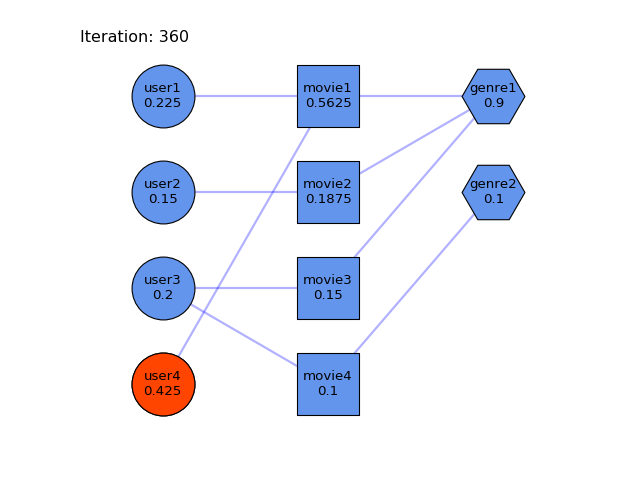

In [25]:
def draw_my_graph(title, node_types, edges, labels, node_shapes,
               node_size=3200, node_color='cornflowerblue', node_alpha=1,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=2,
               edge_text_pos=0.5,
               text_font='sans-serif'):

    # create networkx graph
    G=nx.Graph()
    
    for nodes in node_types:
        G.add_nodes_from(nodes)
    
    G.add_edges_from(edges)
    
        
    graph_pos = {}

    # Update position for node from each type
    for types_i, nodes in enumerate(node_types):
        for node_i, node in enumerate(nodes):
            new_ele = {(node, (types_i, -node_i))}
            graph_pos.update(new_ele)
       
    
    # draw graph
    for i, nodes in enumerate(node_types):
        nx.draw_networkx_nodes(G, graph_pos, nodelist=node_types[i], 
                               node_size=node_size, node_shape = node_shapes[i],
                               alpha=node_alpha, node_color=node_color)
    
    # color user4
    nx.draw_networkx_nodes(G, graph_pos, nodelist=[node_types[0][3]], 
                               node_size=node_size, node_shape = node_shapes[0],
                               alpha=node_alpha, node_color='orangered')
    
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    edge_labels = dict(zip(edges, labels))
    #nx.draw_networkx_edge_labels(G, graph_pos, edge_labels=edge_labels, 
     #                            label_pos=edge_text_pos)

    # show graph
    #fig = plt.figure(figsize=(4,3))
    plt.title(title, loc='left')
    plt.axis('off')

    plt.show()


def create_and_draw_my_graph(iteration, result_vector):
    #create graph
    user_nodes  = ['user1', 'user2', 'user3', 'user4']
    movie_nodes = ['movie1', 'movie2', 'movie3', 'movie4']
    genre_nodes = ['genre1', 'genre2']

    #add percents
    for i, user in enumerate(user_nodes):
        val = round(float(result_vector[i]),4)
        user_nodes[i] = user_nodes[i] + '\n' + str(val)
    
    for i, movie in enumerate(movie_nodes):
        val = round(float(result_vector[i+len(user_nodes)]),4)
        movie_nodes[i] = movie_nodes[i] + '\n' + str(val)
    
    for i, genre in enumerate(genre_nodes):
        val = round(float(result_vector[i+len(user_nodes)+len(movie_nodes)]),4)
        genre_nodes[i] = genre_nodes[i] + '\n' + str(val)

    user_movie_edges = [(user_nodes[0], movie_nodes[0]), 
                        (user_nodes[1], movie_nodes[1]), 
                        (user_nodes[2], movie_nodes[2]), 
                        (user_nodes[2], movie_nodes[3]), 
                        (user_nodes[3], movie_nodes[0])]

    movie_genre_edges = [(movie_nodes[0], genre_nodes[0]), 
                         (movie_nodes[1], genre_nodes[0]), 
                         (movie_nodes[2], genre_nodes[0]), 
                         (movie_nodes[3], genre_nodes[1]),]

    edges = []
    edges.extend(user_movie_edges)
    edges.extend(movie_genre_edges)

    # you may name your edge labels
    #labels = map(chr, range(65, 65+len(graph)))
    #draw_graph(graph, labels)

    labels = range(10)

    node_shapes=["o", "s", "H"]

    title= 'Iteration: '+str(iteration)

    # if edge labels is not specified, numeric labels (0, 1, 2...) will be used
    draw_my_graph(title=title, node_types=[user_nodes,movie_nodes,genre_nodes], edges=edges, 
                  labels=labels, node_shapes= node_shapes)
        
# 
plot_iteration = 360
create_and_draw_my_graph(plot_iteration, iteration_results[plot_iteration])